# Sentiment Analysis 

The identification of sentiment in text is an important field of study, it usually involves detecting whether a piece of text expresses a POSITIVE, a NEGATIVE, or a NEUTRAL sentiment; the sentiment can be general or about a specific topic, e.g., a person, a product, or an event. Sentiment analysis has been part of the international workshop on Semantic Evaluation ([SemEval](https://en.wikipedia.org/wiki/SemEval)) for multiple years.

The task is to implement a neural network that predicts sentiment (POSITIVE, NEGATIVE, NEUTRAL) for a given text. In the following sections, an approach of dataset preperation, ML model, training and evaluation etc. are provied step by step.


## Dataset

The dataset used to train and test this model is generated from German Amazon reviews. The input is the text of the review, and the network will try to predict the star ratings.

Only reviews with 1,3 and 5 star ratings, other reviews with rating 2 and 4 are not included in this dataset. Here: 
* 1 is considered negative
* 3 is considered neutral
* 5 is considered positive


### Loading the data

This code block will read necessary data and gives basic info about the dataset using 'reviews' module, However, the module is not free. 

In [ ]:
from reviews import get_reviews
titles,bodies,ratings,labels,_ = get_reviews()

Total number of reviews: 130762
Counter({'5': 97593, '1': 17476, '3': 15693})


The number of reviews is originally not equally distributed among the ratings, so the positive reviews from the dataset is downsampled so that there is the same number for each rating. The discarded reviews are picked at random.

In [ ]:
from collections import Counter
Counter(ratings)

Counter({1: 15693, 3: 15693, 5: 15693})

#### Examples

Printing out some data examples:

In [ ]:
for idx in range(40,45):
    #print("title:\n %s" % titles[idx])
    print("body:\n %s" % bodies[idx])
    print("rating: %d" % ratings[idx])
    print("label: %d" % labels[idx])
    print("=========================================================================================")

body:
 Wenn man STAR TREK NEMESIS(2002) gesehen hat und ihn mit seinen Vorgänger vergleicht, dann schneidet DER AUFSTAND(1998) in fast allen Belangen schlechter ab.
Schon in der Story selbst gab es Macken. DER AUFSTAND sollte im Gegensatz zu DER ERSTE KONTAKT (1996) wieder ein richtiges THE NEXT GENERATION-Abenteuer werden. Mit einer weitreichenden Philosophie und einer Prise subtilen Humors wollten die Produzenten an die Zeiten der erfolgreichen TV-Serie anknüpfen. Doch sie scheiterten !
Die Geschichte um den Kampf der ENTERPRISE-Crew für ein uninteressantes Volk, gepaart mit einer herbeizitierten Verschwörung um einen Sternflottenadmiral und den äußerst langweiligen So'na erwies sich als Genickbruch. Zu langatmig, unspektakulär und aufgesetzt kommt DER AUFSTAND daher. Zwar hat Regisseur und Co-Star Jonathan"Riker"Frakes hervorragende Arbeit beim Set-Design und den Charakterzeichnungen geleistet, aber dem schwachen Drehbuch von Ex-DEEP SPACE NINE- und VOYAGER-Produzenten Michael Pille

### Word Embeddings and Features

To convert text to vector space, we use [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) where words from the vocabulary are mapped to vectors of real numbers.

Multiple versions of the word embeddings have already been implemented, we use Facebook's [FastText](https://research.fb.com/fasttext/) library.


In [ ]:
import numpy as np
import fasttext

Loading the Fasttext model (the following code might take some time to run, because the model is big)

In [ ]:
fasttext_model_path = '/data/detext_tuning_0041.bin'
fasttext_model = fasttext.load_model(fasttext_model_path, encoding='utf-8')

All texts in the dataset are convert into sequences of word indices. A "word index" would simply be an integer ID for the word. The sequences will be truncated to a maximum length of 200 words. If sequences are shorter than 200, then we need to pad them with zeros.



In [ ]:
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = fasttext_model.dim

### Task 1: Building a Vocabulary

Build a vocabulary from the dataset, the vocabulary should be a dictionary where the key is the word and the value is a unique word index (vocabulary[string] = int). Please consider the size of the vocabulary, and how it affects the training process.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_features = 2000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=max_features,oov_token=oov_tok, split=' ')
tokenizer.fit_on_texts(bodies)
vocabulary=tokenizer.word_index

In [ ]:
vocabulary['ich']

5

From texts to sequences of word indices.

In [ ]:
from keras.preprocessing.sequence import pad_sequences 

'''
sequences = []
for text in bodies:
    text = text.split()
    text_sequence = []
    for word in text:
        text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
'''

bodies_seq = tokenizer.texts_to_sequences(bodies)
bodies_seq = pad_sequences(bodies_seq, maxlen=MAX_SEQUENCE_LENGTH)

Using TensorFlow backend.


### Splitting into Train/Val/Test Sets

Split the dataset into 3 sets: train, validation and test.

We use ```sklearn.model_selection.train_test_split``` twice. First to split to train, val and then split val again into val and test. 

In [ ]:
from sklearn.model_selection import train_test_split

data = {
    'train': {},
    'val': {},
    'test': {},
}

(data['train']['text'],
 data['val']['text'],
 data['train']['y'],
 data['val']['y']
) = train_test_split(bodies_seq, labels, test_size=0.1)

(data['val']['text'],
 data['test']['text'],
 data['val']['y'],
 data['test']['y']
) = train_test_split(data['val']['text'], data['val']['y'], test_size=0.5)

print('Train: {} examples'.format(len(data['train']['y'])))
print('Val: {} examples'.format(len(data['val']['y'])))
print('Test: {} examples'.format(len(data['test']['y'])))

Train: 42371 examples
Val: 2354 examples
Test: 2354 examples


In [ ]:
print(data['test']['text'][0])
print(data['test']['y'][0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   21   13  222
  796  451   66   33  172   25    5   46   10   28  335   76    1    1
  178  161   24  172 1691   35   65  110  560   18   38   28 1287  235
   37   56   29   14    1    4    1    1 1935    3    6   12   40   97
    1    1   55  165    1    1   38    4    1    1   19   56   12  772
   34    2  419   21    1    1    1  913   97  530  445   42    5  151
    6   83   96  271    8    1  858   62  710 1541    4    1  345  548
   91 

## Neural Network

In [ ]:
import keras
from keras import layers
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from IPython import display

### The Embedding layer

Prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

In [ ]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM)) 
for word, i in vocabulary.items():
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

In [ ]:
#fasttext_model['toll']

### Model Definition

In [ ]:
class BaselineModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Input')
        embedding_layer = layers.Embedding(len(vocabulary) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, name='Embedding')(input_layer)
            
        fc_layer = layers.Dense(units=100, name='FullyConnected')(embedding_layer)
        
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(3, name='Output')(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse')

In [ ]:
model = BaselineModel()
model.compile()

Instructions for updating:
Colocations handled automatically by placer.


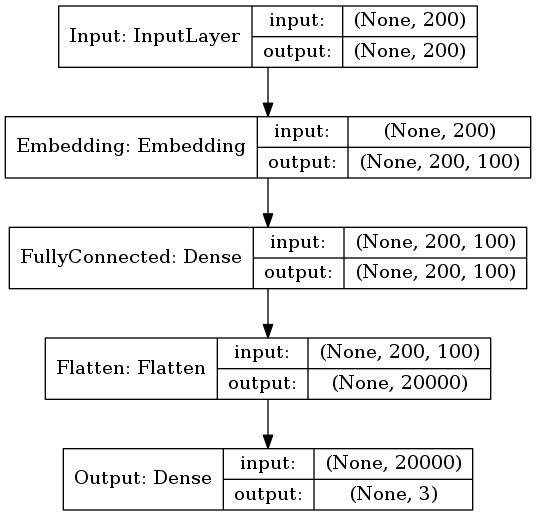

In [ ]:
display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

### Model Training

In [ ]:
history = model.fit([data['train']['text']], keras.utils.to_categorical(data['train']['y'],3),
    epochs=10, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True,)],
    validation_data=([data['val']['text']], keras.utils.to_categorical(data['val']['y'],3)),
    batch_size=128)

Instructions for updating:
Use tf.cast instead.


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

<Figure size 640x480 with 1 Axes>

### Model Evaluation

Let's use accuracy to evaluate our model:

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
h = model.predict([data['test']['text']])

In [ ]:
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(len(predict), resultf1))

Accuracy score on 2354 test samples: 0.617672


### Task 2: Improving the Baseline Model

This model is very simple, and it is clearly overfitting with high different in training and validation sets. Please make some minimal changes to increase its accuracy without increasing the model complexity.

#### Used batch_size=2048, Dense layer units=16, Overfitting reduced and test accuracy reached upto 73.9%

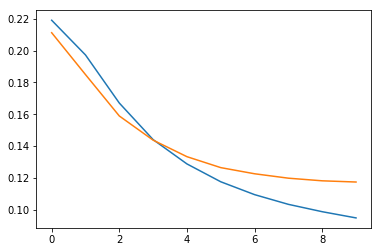

In [ ]:
class InprovingBaselineModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Input')
        embedding_layer = layers.Embedding(len(vocabulary) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, name='Embedding')(input_layer)
            
        fc_layer = layers.Dense(units=16, name='FullyConnected' )(embedding_layer)
        
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(3, activation='softmax', name='Output')(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile( optimizer=keras.optimizers.Adam(lr=0.001), loss='mse')
        
model = InprovingBaselineModel()
model.compile()

history = model.fit([data['train']['text']], keras.utils.to_categorical(data['train']['y'],3),
    epochs=10, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, )],
    validation_data=([data['val']['text']], keras.utils.to_categorical(data['val']['y'],3) ),
    batch_size=2048)

import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

In [ ]:
h = model.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(len(predict), resultf1))


Accuracy score on 2354 test samples: 0.739592


### Task 3: Test vs. Production Data

Let's assume we have an additional field in our dataset, named "product_id", that contains the id of the product that the review belongs to. There is a total of 400 products in the data.
To train our model, we have randomly split the data into train, test and val, as seen above.
After training the model, we find that the accuracy on the validation set is 0.84 and on the test set is 0.79.   
However, when we apply the model in real life to new reviews, the model is performing significantly worse. Can you explain in the next code block what might have gone wrong?

In [ ]:
'''
So far my understanding goes, the mapping from the input texts to ouput layer is based on the weights of the word-cluster. 
The key of semantic evaluation is the sequnce of words in a sentence, which is missing in the above model. 
For example, let's consider 'gut' is positive, 'nicht gut' is negative and 'nicht so gut' is neutral. 
If the embedding space considers two words 'nicht', and 'gut' in the opposite direction and the third one 'so' in the middle,
then the model might wrongly predict 'nicht gut' as neural. Similarly, depending on the weights of the model 'nicht so gut' 
could be wrongly predicted as either positive or negative. So it would be necessary to use a recurrent network in order to 
catch the true semantics. 

To have a more precise assessment, I think, it might be necessary to visualize confusion matrix and then analyze 
product-wise some of the wrongly predicted texts. 
'''

"\nSo far my understanding goes, the mapping from the input texts to ouput layer is based on the weights of the word-cluster. \nThe key of semantic evaluation is the sequnce of words in a sentence, which is missing in the above model. \nFor example, let's consider 'gut' is positive, 'nicht gut' is negative and 'nicht so gut' is neutral. \nIf the embedding space considers two words 'nicht', and 'gut' in the opposite direction and the third one 'so' in the middle, then the model might wrongly predict 'nicht gut' as neural. \nSimilarly, depending on the weights of the model 'nicht so gut' could be wrongly predicted as either positive or negative. \nSo it would be necessary to use a recurrent network in order to catch the true semantics. \n\nTo have a more precise assessment, I think, it might be necessary to visualize confusion matrix and then analyze product-wise some of the wrongly predicted texts. \n"

### Inference

In [ ]:
def infer(texts):
    sequences = []
    for text in texts:
        text = text.split()
        text_sequence = []
        for word in text:
            if word in vocabulary:
                text_sequence.append(vocabulary[word])
        sequences.append(text_sequence)

    padded_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict([padded_seq])
    

In [ ]:
text = ['das ist schlecht',
       'ich finde das echt toll',
       'das ist gut',
       'das ist nicht schlecht',
       'das ist nicht gut',
       'okay vielen dank',]


In [ ]:
h_ = infer(text)
for i,t in enumerate(text):
    print('{} {} {}'.format(np.argmax(h_[i]), h_[i], t[:MAX_SEQUENCE_LENGTH], ))

0 [0.58312947 0.35983658 0.05703396] das ist schlecht
2 [0.1554293  0.27646726 0.56810343] ich finde das echt toll
1 [0.17970131 0.51889807 0.30140063] das ist gut
0 [0.71345586 0.26710415 0.01943989] das ist nicht schlecht
1 [0.3106428  0.5442085  0.14514858] das ist nicht gut
2 [0.19429103 0.34386858 0.46184048] okay vielen dank


### Task 4: CNN/LSTM Model

Implement a model similar to the one described in [this paper](https://arxiv.org/pdf/1704.06125.pdf), in order to get an even higher accuracy.

#### kernel_size = 5, filters = 32,36, pool_size = 4 gives 75% test accuracy

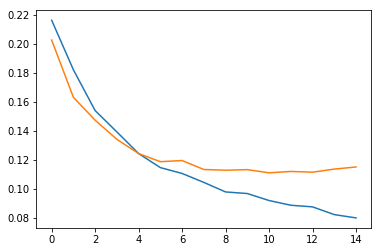

Accuracy score on 2354 test samples: 0.752336


In [ ]:
# Convolution
kernel_size = 5
filters = 36
pool_size = 4

class ModelWithCNNLSTM(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Input')
        embedding_layer = layers.Embedding(len(vocabulary) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding')(input_layer)
        
        conv1d_layer = layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1)(embedding_layer) #
        maxPool1D_layer = layers.MaxPooling1D(pool_size=pool_size)(conv1d_layer) 
        #lstm_layer = layers.LSTM(lstm_out)(maxPool1D_layer)
        lstm_layer = layers.Bidirectional(layers.LSTM(100))(maxPool1D_layer)
        fc_layer = layers.Dense(units=16,name='FullyConnected')(lstm_layer)
                
        predictions = layers.Dense(3,name='Output', activation='softmax')(fc_layer) #
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='mse')
        
model = ModelWithCNNLSTM()
model.compile()

#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

history = model.fit([data['train']['text']], keras.utils.to_categorical(data['train']['y'],3), epochs=15, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, )],
    validation_data=([data['val']['text']], keras.utils.to_categorical(data['val']['y'],3)), batch_size=2048)

import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_


h = model.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(len(predict), resultf1))

###  Task 5: Custom Model

If you want you can implement further models that deviate from the paper, if you think they may perform better.

##### Dropout layer does not help

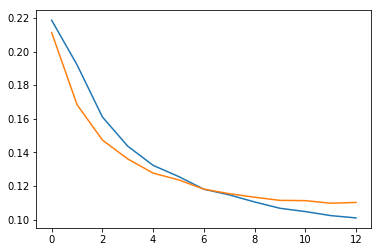

Accuracy score on 2354 test samples: 0.751487


In [ ]:
# Convolution
kernel_size = 5
filters = 36
pool_size = 4

class ModelWithCNNLSTM(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Input')
        
        embedding_layer = layers.Embedding(len(vocabulary) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding')(input_layer)
        embedding_layer = layers.Dropout(0.2)(embedding_layer)
        
        conv1d_layer = layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1)(embedding_layer) #
        maxPool1D_layer = layers.MaxPooling1D(pool_size=pool_size)(conv1d_layer) 
        
        #lstm_layer = layers.LSTM(lstm_out)(maxPool1D_layer)
        lstm_layer = layers.Bidirectional(layers.LSTM(100))(maxPool1D_layer)
        #lstm_layer = layers.Dropout(0.2)(lstm_layer)
        
        fc_layer = layers.Dense(units=16,name='FullyConnected')(lstm_layer)
                
        predictions = layers.Dense(3,name='Output', activation='softmax')(fc_layer) #
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='mse')
        
model = ModelWithCNNLSTM()
model.compile()

#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

history = model.fit([data['train']['text']], keras.utils.to_categorical(data['train']['y'],3), epochs=13, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, )],
    validation_data=([data['val']['text']], keras.utils.to_categorical(data['val']['y'],3)), batch_size=2048)

import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_


h = model.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(len(predict), resultf1))

##### Only Conv1d+pooling layer gives similar (75.5%) test accuracy 

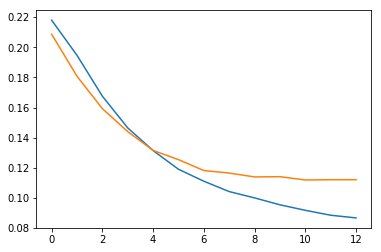

Accuracy score on 2354 test samples: 0.754885


In [ ]:
# Convolution
kernel_size = 5
filters = 36
pool_size = 4

class ModelWithCNNLSTM(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Input')
        
        embedding_layer = layers.Embedding(len(vocabulary) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding')(input_layer)
               
        conv1d_layer = layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1)(embedding_layer) #
        maxPool1D_layer = layers.MaxPooling1D(pool_size=pool_size)(conv1d_layer) 
        
        fc_layer = layers.Dense(units=16,name='FullyConnected')(maxPool1D_layer)
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
                
        predictions = layers.Dense(3,name='Output', activation='softmax')(fc_layer) #
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='mse')
        
model = ModelWithCNNLSTM()
model.compile()

#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

history = model.fit([data['train']['text']], keras.utils.to_categorical(data['train']['y'],3), epochs=10, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, )],
    validation_data=([data['val']['text']], keras.utils.to_categorical(data['val']['y'],3)), batch_size=2048)

import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_


h = model.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(len(predict), resultf1))